# Table of Content

1) Importing the Libraries

2) Loading the Data

3) Cleaning the Data

4) Categorical Analysis

5) Numerical Analysis

## Importing the Libraries

In [4]:
import numpy as np 
import pandas as pd
import plotly.express as px

import matplotlib.pyplot as plt
import seaborn as sns



import warnings
warnings.filterwarnings('ignore')


## Loading the Data

In [5]:
data=pd.read_csv('hotel_bookings.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

## Cleaning the Data

In [6]:
#First of all I take a copy of the dataset
df=data.copy()
#Convert Date columns to DateTime:
df['reservation_status_date']=pd.to_datetime(df['reservation_status_date'])

Check for null values:

In [7]:
null_columns=df.columns[df.isnull().sum()>0]
df[null_columns].isnull().sum().sort_values(ascending=False)

company     112593
agent        16340
country        488
children         4
dtype: int64

### Observations on Null Values in the Dataset

- **Company** contains a large number of null values compared to the rest of the dataset. The best approach may be to remove this column if it does not add significant value to the analysis.
- **Agent** requires further examination to determine the most suitable method for handling its null values.
- **Children** and **Country** have some null values, which can be easily addressed using appropriate imputation techniques.

In [8]:
df.drop(columns=['company'],inplace=True)

df.dropna(subset=['country','children'],inplace=True)

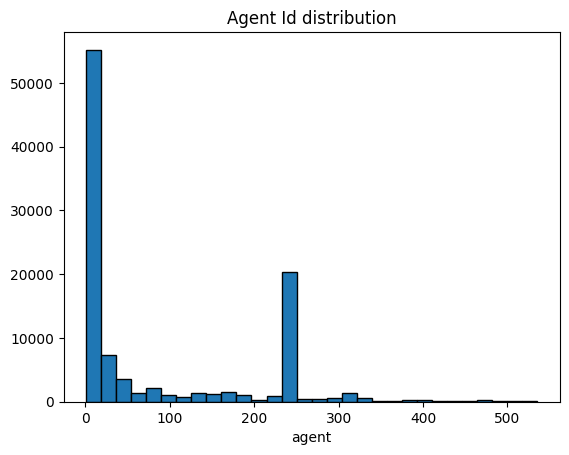

In [9]:
plt.figure()
plt.hist(df['agent'],edgecolor='black',bins=30)
plt.xlabel('agent')
plt.title('Agent Id distribution')
plt.show()

### Agent null values analysis

Since most **agent** values are below 50 and the distribution is **highly skewed to the right**, it suggests that a few travel agencies dominate hotel bookings, while many others contribute in much smaller numbers.

### Solution
Agent ID **0** represents cases where no agency was involved. To maintain consistency, I replace `NaN` values with `0` in the dataset.


In [10]:
df['agent']=df['agent'].fillna(0)

Check for duplicated rows:

In [11]:
print(f'Duplicated Rows: {df.duplicated().sum()}')

Duplicated Rows: 31965


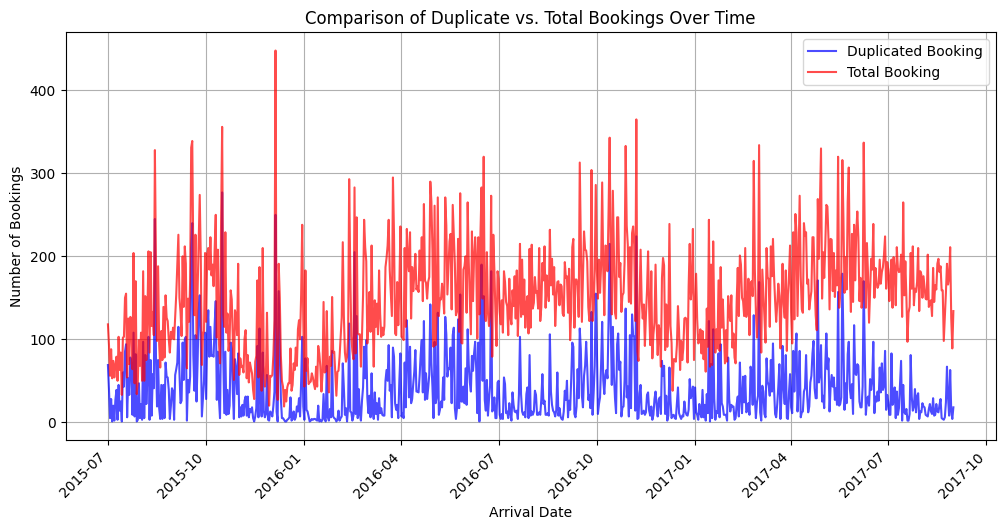

In [12]:
#Let's take a look at duplicated rows:
df['arrival_date'] = pd.to_datetime(df[['arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month']].astype(str).agg('-'.join, axis=1))
duplicats_dated=df[df.duplicated()].groupby('arrival_date').size()

total_booking_dated=df.groupby('arrival_date').size()

plt.figure(figsize=(12,6))

duplicats_dated.plot(kind='line',label='Duplicated Booking',color='b',alpha=0.7)
total_booking_dated.plot(kind='line',label='Total Booking',color='r',alpha=0.7)

plt.xlabel("Arrival Date")
plt.ylabel("Number of Bookings")
plt.title("Comparison of Duplicate vs. Total Bookings Over Time")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

### Duplicate Booking Trend

The number of **duplicated bookings** increases proportionally with the total number of bookings. This suggests that duplicates are more common during peak demand periods rather than occurring randomly.

### Possible Reasons for This Trend:
- **Bulk Reservations:** Hotels may receive multiple identical bookings from travel agencies or group bookings, particularly during high-demand seasons.
- **System Limitations:** Some booking platforms might inadvertently generate duplicate reservations when processing large volumes of bookings quickly.
- **Repeat Guest Bookings:** Guests may make multiple reservations for the same stay due to **price fluctuations** or concerns about **room availability**.

Understanding this trend can help optimize **booking systems, pricing strategies, and inventory management** for hotels.


Comparing Duplicates with Cancellation:

<Figure size 1200x600 with 0 Axes>

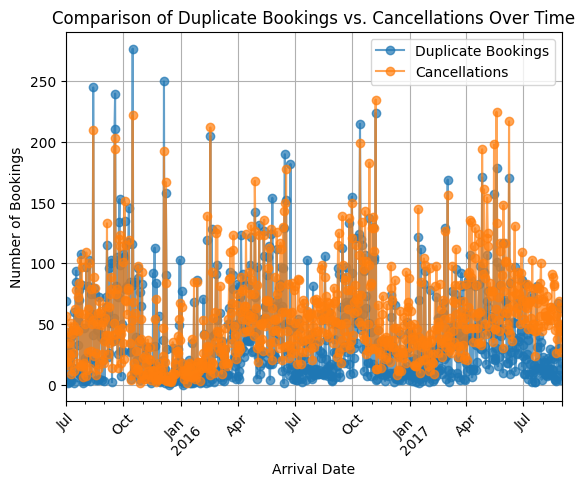

In [13]:
# Count total cancellations per arrival date
cancellations_dated=df[df['is_canceled']==1].groupby('arrival_date').size()

# Combine duplicate and cancellation counts
cancelled_vs_duplicate=pd.DataFrame({'duplicated':duplicats_dated,'cancelled':cancellations_dated}).fillna(0)

plt.figure(figsize=(12,6))

cancelled_vs_duplicate.plot(kind='line',marker='o',alpha=0.7)

plt.xlabel("Arrival Date")
plt.ylabel("Number of Bookings")
plt.title("Comparison of Duplicate Bookings vs. Cancellations Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(["Duplicate Bookings", "Cancellations"])
plt.show()

In [14]:
cancelled_vs_duplicate.corr()

,duplicated,cancelled
duplicated,1.000000,0.829854
cancelled,0.829854,1.000000


### Relationship Between Duplicates and Cancellations

- There is a strong correlation between duplicate bookings and cancellations, suggesting that repeated reservations may contribute to higher cancellation rates.


In [15]:
# Group duplicates by agent ID
duplicated_agents=df[df.duplicated()].groupby('agent').size().sort_values(ascending=False)
duplicated_agents.head(10)

agent
1.0      5959
0.0      4142
9.0      3204
6.0      2169
37.0     1005
3.0       973
19.0      910
240.0     895
21.0      676
29.0      599
dtype: int64

### Observations on Agent Bookings

- **Agents 1.0, 0.0, 6.0, and 9.0** account for a significant share of duplicate bookings.
- **Agent 0.0** represents "no agent" or direct hotel bookings.
- **Long-tail effect**: Many agents contribute only a small number of duplicate bookings, indicating that bulk reservations are concentrated among a few top agents.


Compare Duplicate Rates vs. Total Bookings Per Agent Check if the high-duplicate agents also have a high total booking count:

In [16]:
total_bookings_per_agent = df.groupby('agent').size()
cancelation_agents=df[df['is_canceled']==1].groupby('agent').size()
agent_analysis = pd.DataFrame({'total_bookings': total_bookings_per_agent, 'duplicate_bookings': duplicated_agents,'cancellations':cancelation_agents}).fillna(0)
agent_analysis.sort_values(by='duplicate_bookings', ascending=False).head(10)

,total_bookings,duplicate_bookings,cancellations
agent,,,
1.0,7191,5959.0,5280.0
0.0,16004,4142.0,3992.0
9.0,31959,3204.0,13263.0
6.0,3283,2169.0,1020.0
37.0,1229,1005.0,717.0
3.0,1336,973.0,771.0
19.0,1061,910.0,780.0
240.0,13871,895.0,5484.0
21.0,875,676.0,506.0


### Duplicate Booking Analysis: Conclusion

### **Key Findings**
- The number of **duplicate bookings** increases in parallel with total bookings, showing a strong correlation with peak seasons.
- A **high correlation between duplicates and cancellations** suggests that speculative bookings or bulk reservations may contribute to cancellations.
- **Specific agents**, such as **Agent 1.0, 9.0, and others**, are responsible for a disproportionate number of duplicate bookings, potentially due to agency reservation strategies.
- Duplicate bookings are more frequent between **January–July** and **April–October**, indicating a seasonal pattern.

Flagging agents with the highest number of duplicates:

In [17]:
df['duplicate_flag']=df.duplicated()
high_duplicate_agents = df[df['duplicate_flag'] == True].groupby('agent').size().sort_values(ascending=False).head(10)
#We can list the agents with high ratio of duplicate bookings.
high_duplicate_agents


agent
1.0      5959
0.0      4142
9.0      3204
6.0      2169
37.0     1005
3.0       973
19.0      910
240.0     895
21.0      676
29.0      599
dtype: int64

## Categorical Analysis

In [18]:
df.describe(include=object)

,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,reservation_status
count,118898,118898,118898,118898,118898,118898,118898,118898,118898,118898,118898
unique,2,12,5,177,7,5,10,12,3,4,3
top,City Hotel,August,BB,PRT,Online TA,TA/TO,A,A,No Deposit,Transient,Check-Out
freq,79302,13852,91863,48586,56402,97730,85601,73863,104163,89174,74745


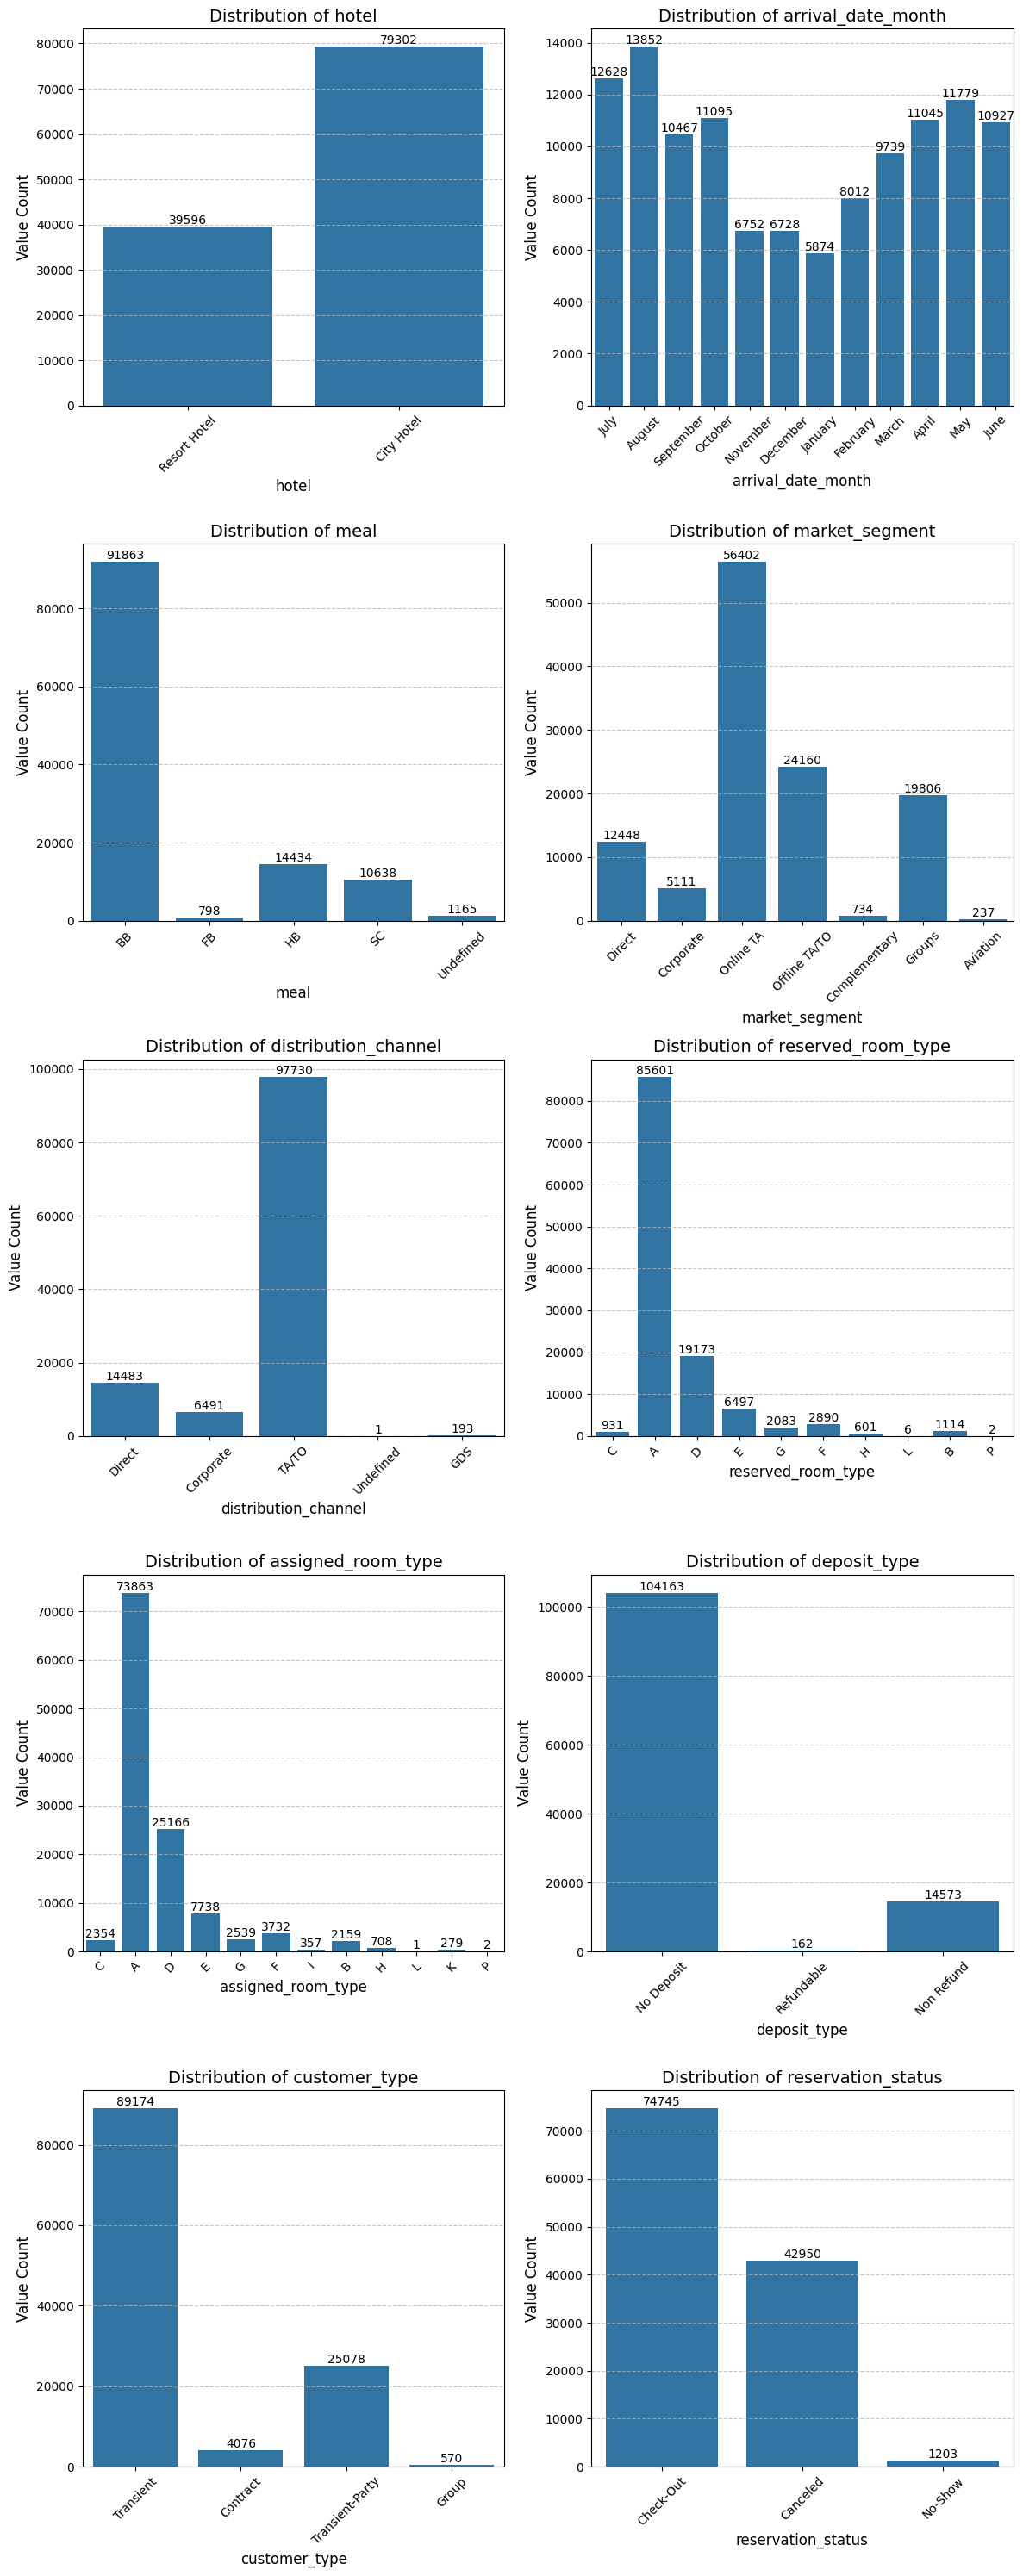

In [19]:
categorical_columns=[i for i in df.columns if df[i].dtypes==object and i not in ['country','reservation_status_date']]

num_cols = 2  
num_rows = (len(categorical_columns) + 1) // num_cols  

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, num_rows * 6))  # Adjust size
axes = axes.flatten()  

for idx, col in enumerate(categorical_columns):
    ax = axes[idx]  
    sns.countplot(data=df.dropna(), x=col, ax=ax)  
    
    for container in ax.containers:
        ax.bar_label(container)
    
    ax.set_title(f"Distribution of {col}", fontsize=14)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel("Value Count", fontsize=12)
    
    ax.set_xticks(ax.get_xticks()) 
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    
    ax.grid(axis='y', linestyle='--', alpha=0.7)

for i in range(idx + 1, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()  
plt.show()


You can see the distribution of bookings grouped by country:

In [ ]:
!pip install plotly


In [20]:
country_counts = df['country'].value_counts().reset_index()
country_counts.columns = ['country', 'count']

fig = px.choropleth(country_counts, locations="country",
                     locationmode="ISO-3",
                     color="count",
                     color_continuous_scale="Viridis",
                     title="Hotel Reservations by Country")
fig.show()

### Categorical Data Frequency Observations

### **Hotel Type Distribution**
The number of City Hotels in this dataset is **almost twice as large** as the number of Resort Hotels.  
This suggests a **higher booking volume** for City Hotels, likely driven by **business travel and short-term stays**, while Resort Hotels may cater more to **leisure travelers with longer stays**.

### **Market Segment Analysis**
**Online Travel Agencies (OTA) dominate the market segment by a large margin.**  
This indicates that most bookings come from **third-party online platforms**, which often provide **flexible policies and dynamic pricing**, influencing cancellation rates and booking behaviors.

### **Customer Type Analysis**
The majority of customers fall into the **Transient** category.  
This means most guests book **short-term stays** without long-term commitments, leading to **frequent booking turnover** and potentially **higher cancellation rates**.

### **Deposit Type Distribution**
The most common deposit type is **"No Deposit"**, indicating that most bookings do not require upfront payments.  
This suggests:
- **Higher likelihood of cancellations**, as guests can cancel without financial penalties.
- **Revenue uncertainty**, since bookings are not guaranteed until check-in.
- Hotels may benefit from offering **discounts for non-refundable bookings** to encourage commitment.

### **Reserved vs. Assigned Room Type**
The most frequently **reserved room type is "A"**, and **Room Type A is also the most frequently assigned** upon check-in.  
However, some reservations for Room Type A were **reassigned**, with most of them being changed to **Room Type D**, which is the second most frequently reserved and assigned room type.  
This pattern suggests that:
- Room Type A has **high availability**, making it the default assignment for most bookings.
- Some reservations may be **reassigned due to availability constraints** or operational adjustments.

### **Reservation Status**

### **Overall Reservation Trends**
- The majority of reservations have been **successfully checked out**, indicating a **high fulfillment rate**.
- Approximately **one-third of all bookings were canceled**, highlighting a notable cancellation trend.
- A portion of reservations also show a **"no-show" status**, meaning guests did not arrive despite having an active booking.

### **Distribution Channel Analysis**

### **TA/TO Dominance**
- The **Travel Agencies/Tour Operators (TA/TO) channel** holds the **largest share** among all distribution channels.
- This suggests that **a significant portion of bookings** come through **third-party travel platforms** rather than direct hotel reservations.

### **Seasonal Booking Trends**

- **Peak Season**: July and August experience the most reservations, possibly due to summer holidays.
- **Off-Peak Season**: November, December, and January have the least bookings, potentially due to winter travel patterns.

### **Country-wise Booking Trends**

- **Portugal (PRT)** and **France (FRA)** lead in most of reservations.
- These trends may be influenced by factors such as travel culture, tourism industry strength, or proximity to popular destinations.

<Figure size 1200x600 with 0 Axes>

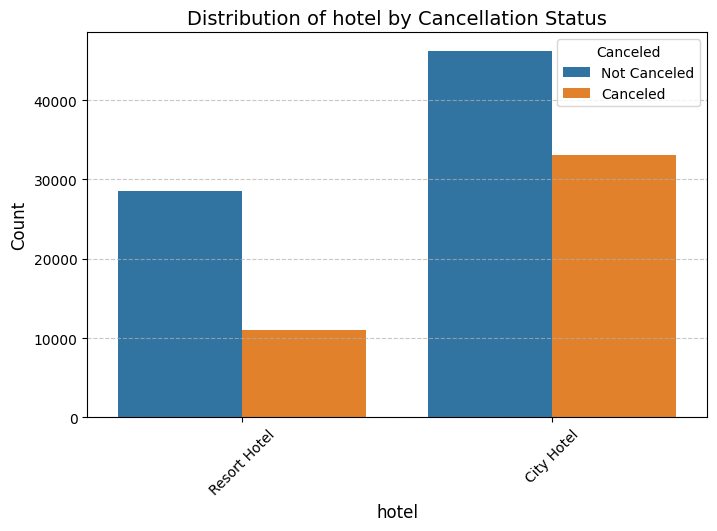

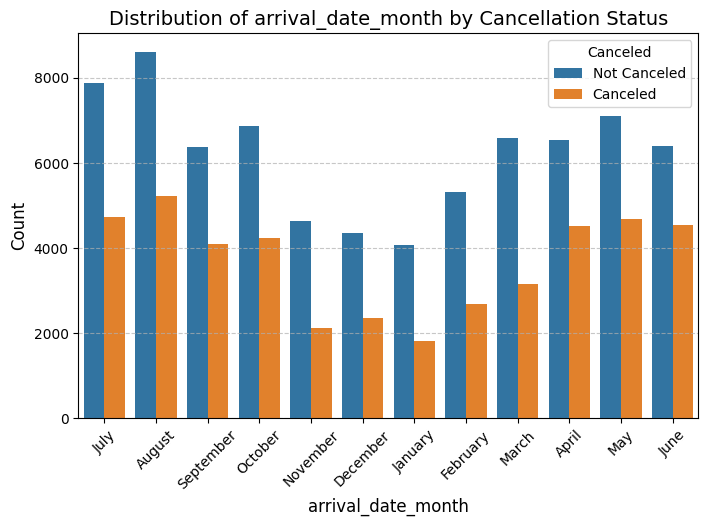

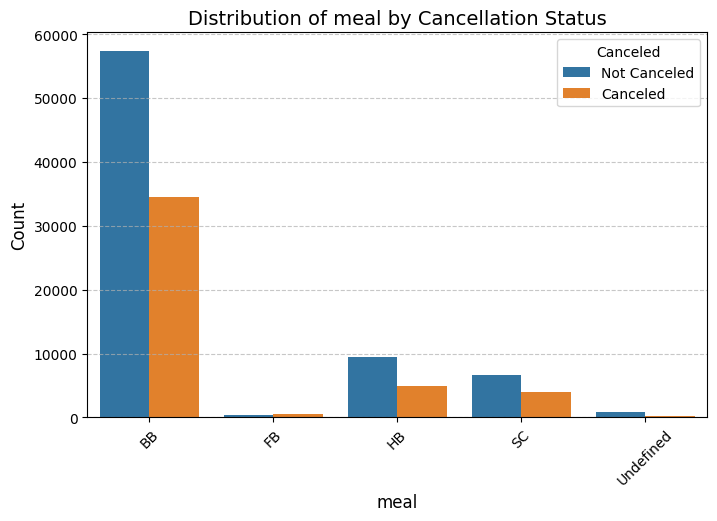

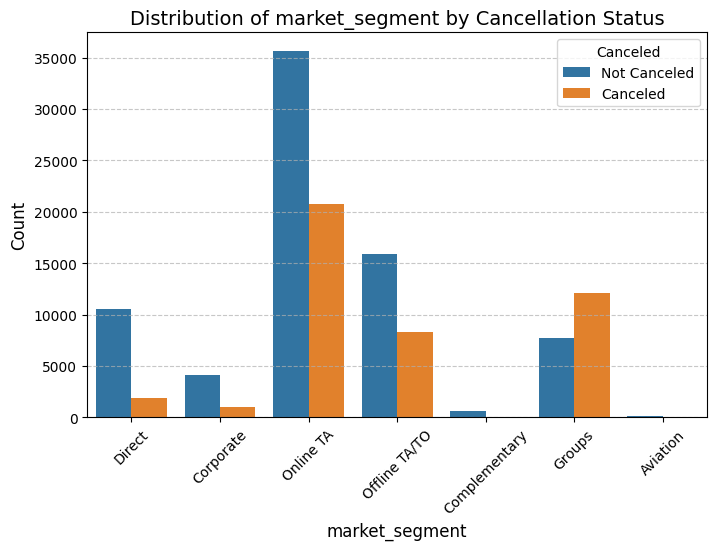

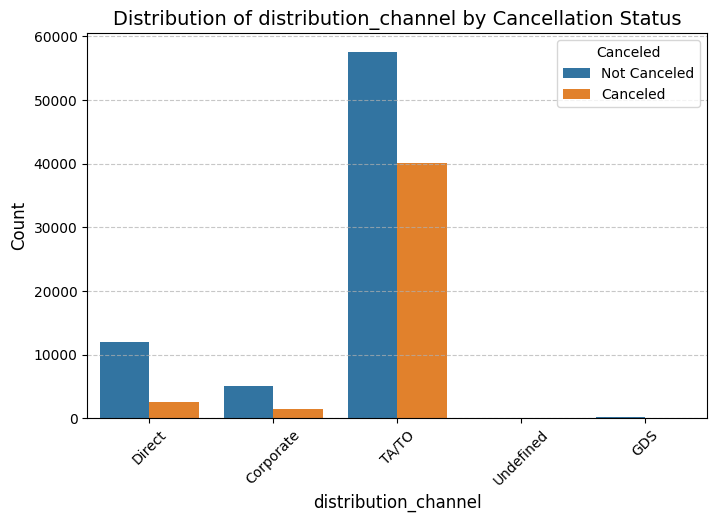

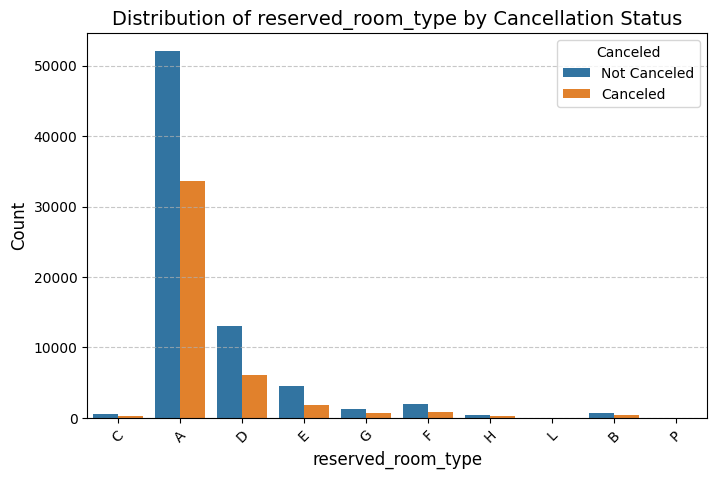

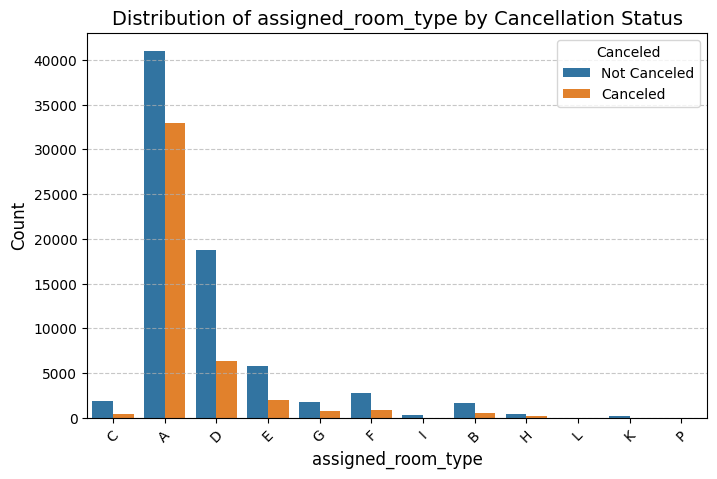

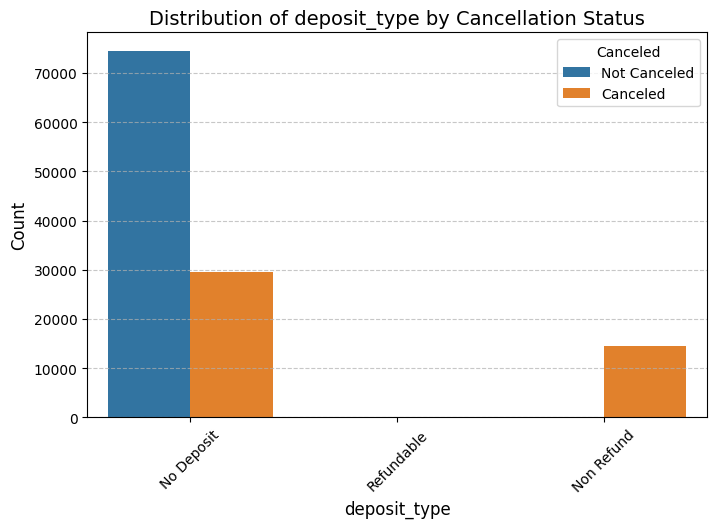

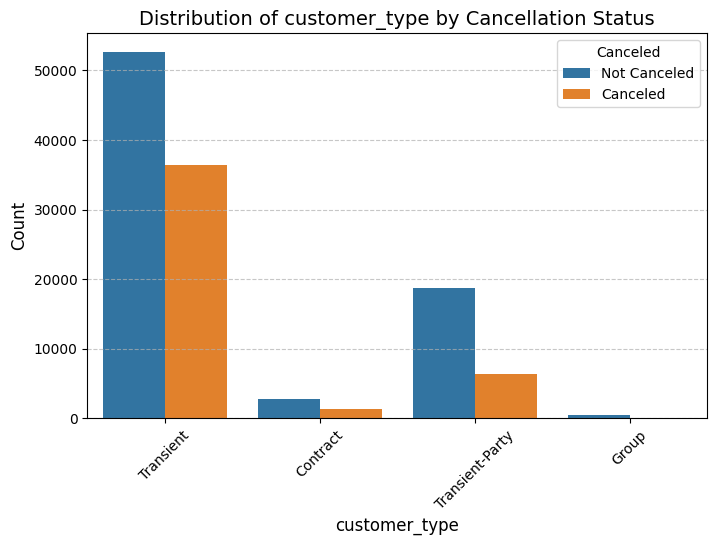

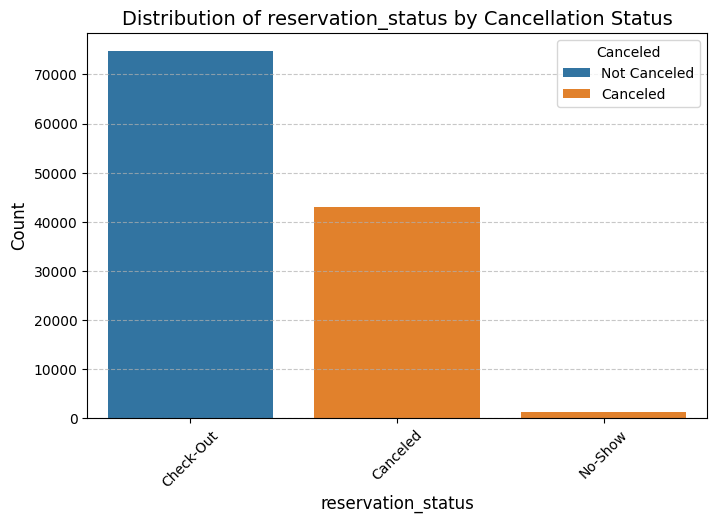

In [21]:
plt.figure(figsize=(12, 6))

for col in categorical_columns:
    plt.figure(figsize=(8, 5))
    ax = sns.countplot(data=df, x=col, hue='is_canceled')  

    plt.title(f"Distribution of {col} by Cancellation Status", fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title="Canceled", labels=["Not Canceled", "Canceled"])  # Adjust legend labels
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

### Categorical Data Observations Comparing to Cancellation

### **Hotel Type & Cancellations**
The **cancellation ratio for City Hotels is higher** than Resort Hotels.  
This suggests that City Hotels might experience **more booking flexibility**, possibly due to **business travelers or short-term stays**, while Resort Hotels may have **longer commitments**, leading to fewer cancellations.

### **Market Segment & Cancellations**
- **Direct bookings have the lowest cancellation ratio**, indicating that guests booking directly with the hotel tend to **commit to their reservations more**.
- **Group bookings have the highest cancellation ratio**, with more reservations canceled than confirmed.  
  This suggests that group reservations may often be **speculative or bulk bookings**, leading to more cancellations.

### **Customer Type & Cancellations**
The **highest cancellation ratio is observed for Transient customers**, meaning **short-term guests cancel more frequently**.  
This pattern is likely due to **last-minute travel plan changes** and **flexible booking options** available to transient travelers.

### **Deposit Type & Cancellations**
Nearly **all non-refundable deposit bookings end up being canceled**.  
This surprising trend might indicate:
- **Guests booking impulsively but later canceling despite non-refundable terms**.
- Potential **policy enforcement issues** where hotels might still allow cancellations.

### **Room Type & Cancellations**
- The **highest cancellation ratio** among reserved room types is for **Room Type H**, even though **it has a very small share** of total reservations.  
  This suggests that Room Type H might be **less preferred**, leading to more cancellations when guests are assigned to it.
- The **cancellation ratio for assigned Room Type A is higher** than for reserved Room Type A.  
  This could indicate cases where guests are **unhappy with reassigned rooms**, leading to more cancellations.


## Numerical Analysis

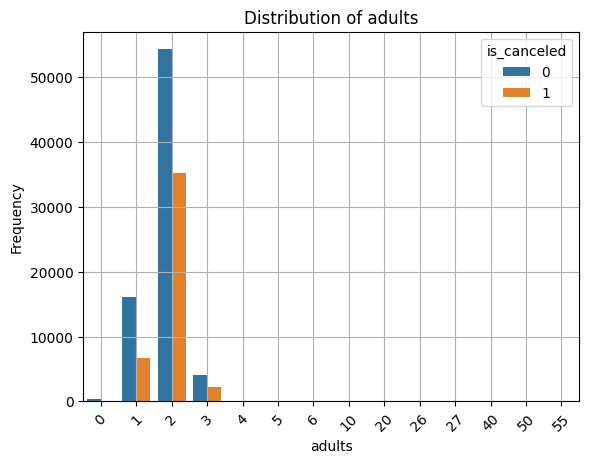

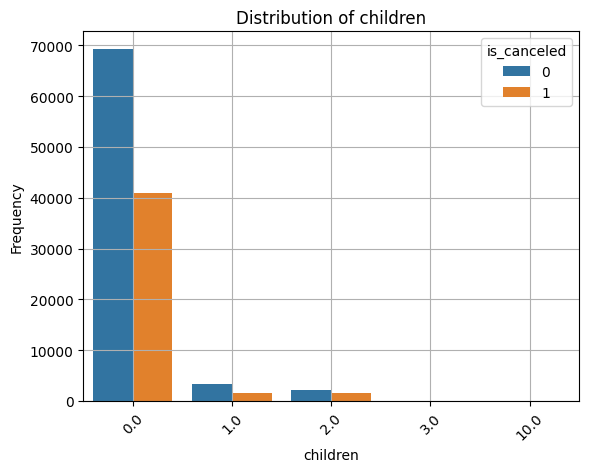

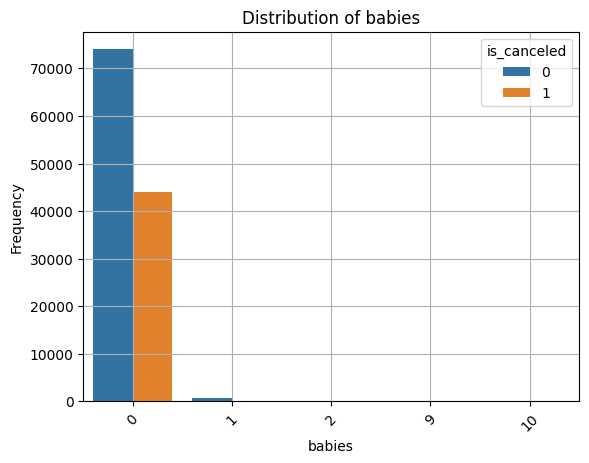

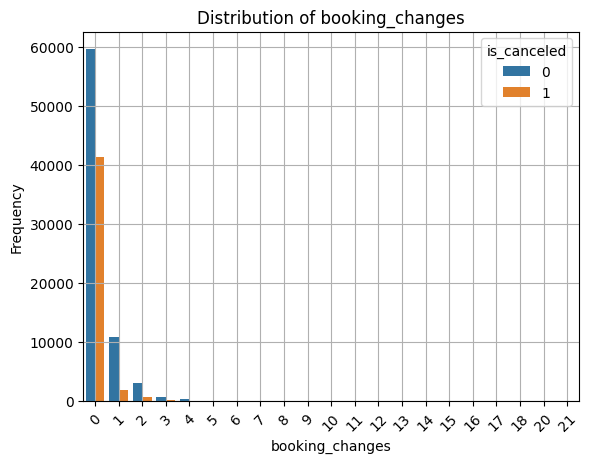

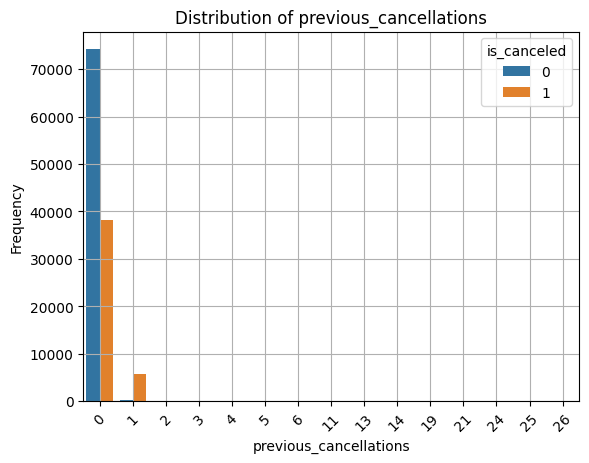

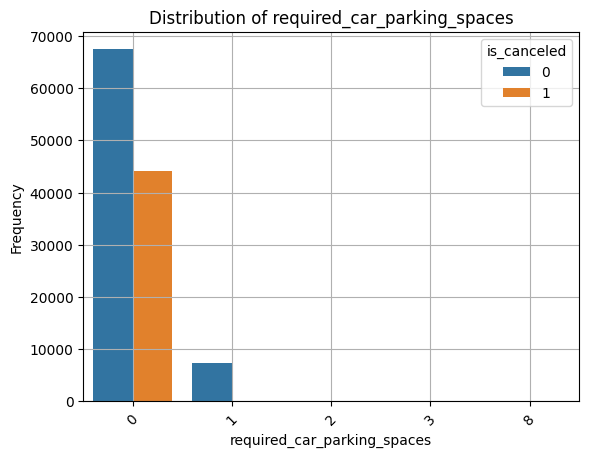

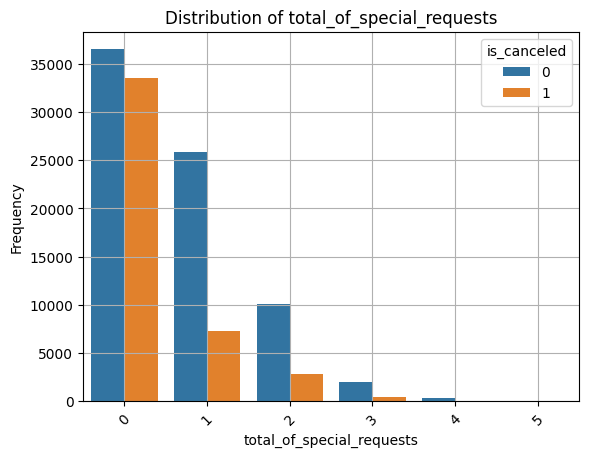

In [22]:
#I seperated some of discrete columns because of they had too much columns for the count plot and I take care of them in upcoming cells

discrete_columns = [ 'adults', 'children', 'babies',
                    'booking_changes', 'previous_cancellations', 
                    'required_car_parking_spaces', 'total_of_special_requests']

for i in discrete_columns:
    plt.figure()
    sns.countplot(data=df,x=i,hue='is_canceled')
    plt.title(f"Distribution of {i}")
    plt.xlabel(i)
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

In [23]:

df[df['adults'] + df['children'] + df['babies'] + df['is_canceled'] == 0 ]['market_segment'].value_counts()

market_segment
Online TA        65
Offline TA/TO    28
Direct           24
Groups           17
Corporate        12
Complementary     7
Aviation          2
Name: count, dtype: int64

### Handling Bookings with Zero Guests

- Some bookings with zero **adults, children, and babies** were canceled, which does not pose an issue. However, for those that were **not canceled**, there are three possible explanations:
    - **Data Entry Error**: Incorrect or incomplete information during the booking process.
    - **Group Bookings Without Individual Guest Details**: Reservations made for large groups, where guest specifics were not recorded.
    - **Special Reservations or Placeholder Entries**: Temporary or administrative bookings that do not represent actual guests.

Since the volume of such cases is insignificant and we lack access to hotel data for verification, we can reasonably classify them as **data entry errors** and proceed with dropping these records.


In [24]:
df.drop(df[df['adults'] + df['children'] + df['babies'] + df['is_canceled'] == 0 ].index,inplace=True)

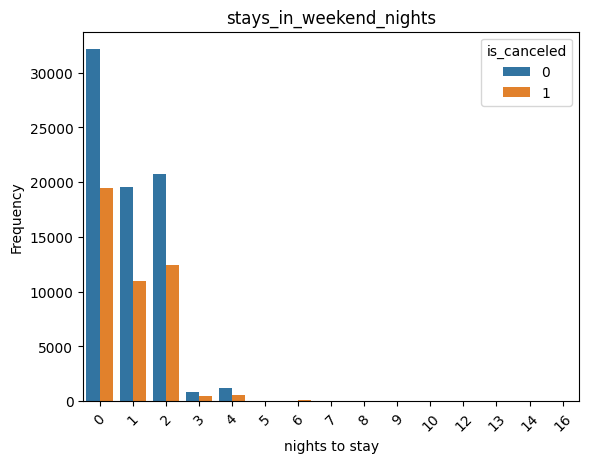

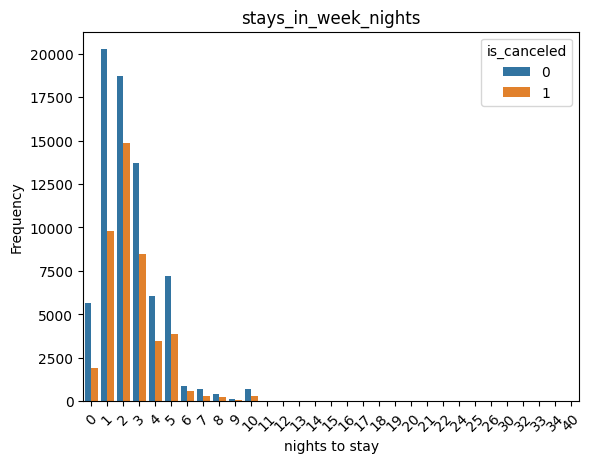

In [25]:
discrete_columns_2=['stays_in_weekend_nights','stays_in_week_nights']
for i in discrete_columns_2:
    sns.countplot(data=df,x=i,hue='is_canceled')
    plt.title(i)
    plt.xlabel('nights to stay')
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.show()

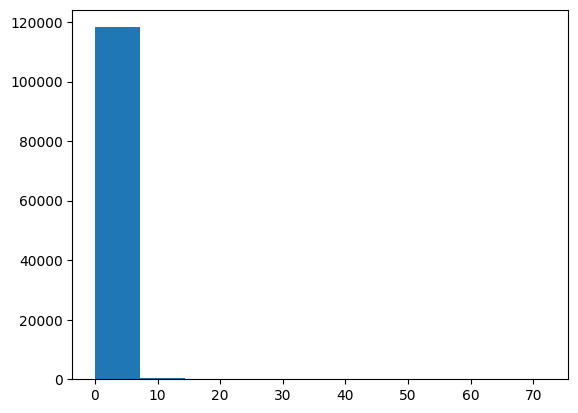

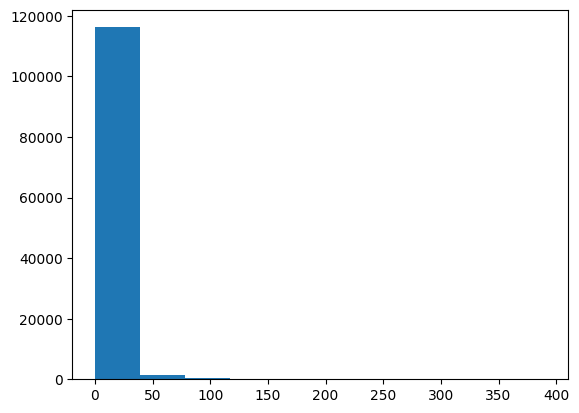

In [26]:
discrete_columns_3=['previous_bookings_not_canceled','days_in_waiting_list']
for i in discrete_columns_3:
    plt.figure()
    plt.hist(df[i])
    plt.show()

In [27]:
for i in discrete_columns_3:
    print(df[i].value_counts())

previous_bookings_not_canceled
0     115353
1       1448
2        536
3        301
4        209
       ...  
68         1
69         1
70         1
71         1
72         1
Name: count, Length: 73, dtype: int64
days_in_waiting_list
0      115050
39        227
58        164
44        141
31        127
        ...  
72          1
81          1
74          1
167         1
36          1
Name: count, Length: 127, dtype: int64


### Distribution of `previous_bookings_not_canceled` and `days_in_waiting_list`

- For both **previous_bookings_not_canceled** and **days_in_waiting_list**, more than 95% of the distribution is concentrated at **0**.
- This suggests that the vast majority of bookings had no prior confirmed reservations, and most guests did not spend time on a waiting list.
- The extreme skew in distribution may indicate that these features have limited predictive value, 


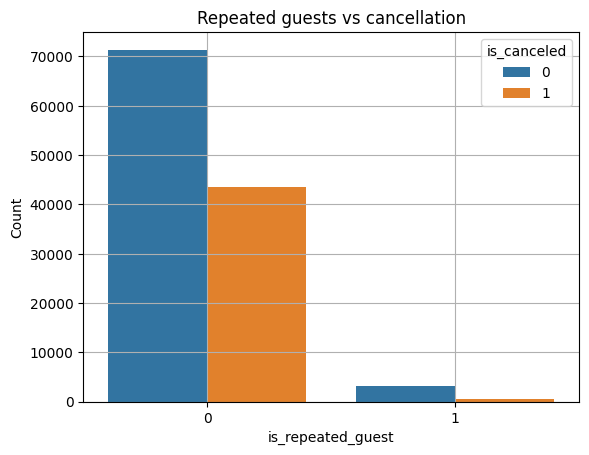

In [28]:
plt.figure()
sns.countplot(data=df,x='is_repeated_guest',hue='is_canceled')
plt.ylabel('Count')
plt.title('Repeated guests vs cancellation')
plt.grid()
plt.show()    

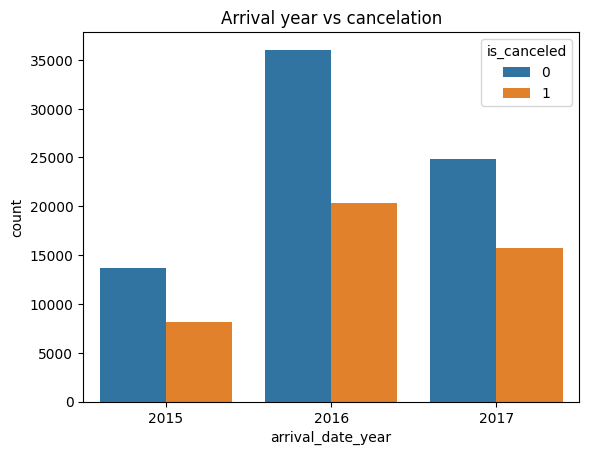

In [29]:
plt.figure()
sns.countplot(data=df,x='arrival_date_year',hue='is_canceled')
plt.title('Arrival year vs cancelation')
plt.show()

### Discrete Numerical Data Observations

### **Adults Distribution**
- The majority of bookings are for **two adults**, indicating that **couple travelers** are the most common.
- **Bookings with children** make up a **small share** of all reservations, with most bookings containing **no children at all**.
- Almost all bookings **do not include babies**, with only a small portion having at least one.

### **Weekend Nights Stay**
- Most guests **who stayed for weekend nights booked for 1 or 2 nights**.
- A significant portion of bookings **did not include weekend stays**.

### **Weekday Nights Stay**
- Most guests **who booked weekday stays chose 1, 2, or 3 nights**, with **2-night stays having the highest cancellation ratio**.
- The next most common durations for weekday stays were **0, 4, or 5 nights**, while **longer stays were rare**.

### **Booking Changes & Cancellations**
- The **largest distribution of bookings** falls under **zero booking changes**.
- Interestingly, reservations with **zero booking modifications also have the highest cancellation ratio**, suggesting that guests tend to either **stick to their original booking or cancel entirely**.

### **Previous Cancellations**
- Almost all bookings **with previous cancellations end up being canceled again**, indicating that guests with a history of cancellations continue the same pattern in future bookings.

### **Car Parking Spaces & Cancellations**
- Bookings that **require zero parking spaces** show a **notably high cancellation ratio**, potentially indicating that many city travelers do not commit to reservations.
- Conversely, bookings that **request at least one parking space show no cancellations**, suggesting that travelers needing parking have more committed plans.

### **Special Requests & Cancellations**
- As the **number of total special requests increases**, the **cancellation ratio decreases**.
- The **highest cancellation ratio** is observed for bookings **with zero special requests**, which could indicate **less committed travelers** or **impulse reservations**.

### **Previous Bookings Not Canceled & Days in Waiting List**
- The distribution of **previous_bookings_not_canceled** shows that **over 95% of reservations** have a value of **zero**.
- Similarly, **days_in_waiting_list** has a **high concentration of zero values**, indicating that most bookings are confirmed **without being placed on a waiting list**.

### Guest Booking Trends

### **First-Time vs. Repeat Guests**
- The majority of guests are **first-time visitors**, indicating a **high influx of new customers**.
- Only a **small percentage of reservations come from repeat guests**, suggesting that **customer retention may be lower** compared to new acquisitions.

### **Booking and Cancellation Trends Over the Years**

- **Most Bookings in 2016**: The dataset indicates that the highest number of reservations occurred in 2016.
- **Highest Cancellation Ratio in 2017**: The year 2017 recorded the largest proportion of cancellations.

### Possible Factors to Consider:
- Changes in travel policies or economic conditions between 2016 and 2017.
- Seasonal effects or promotional offers influencing booking patterns.
- External events (e.g., global tourism trends or disruptions) affecting cancellations.

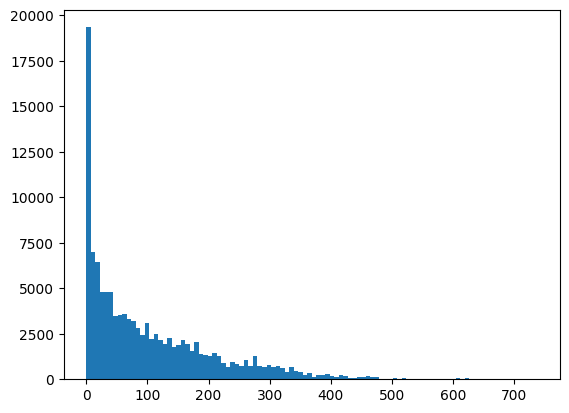

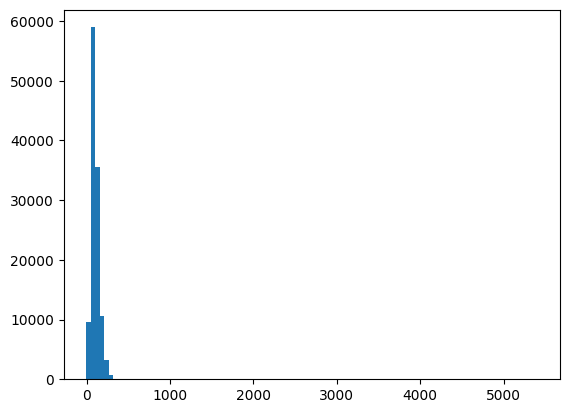

In [30]:
continuous_columns = ['lead_time', 'adr']

for i in continuous_columns:
    plt.figure()
    plt.hist(df[i],bins=100)
    plt.show()

In [31]:
df[continuous_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
lead_time,118743.0,104.404681,106.919810,0.00,18.0,70.0,161.0,737.0
adr,118743.0,102.120541,50.399491,-6.38,70.0,95.0,126.0,5400.0


In [32]:
print('Number of Negative values in adr column:', len(df[df['adr']<0]))

Number of Negative values in adr column: 1


In [33]:
print('values above 500:')
print( df[df['adr']>500]['adr'])

values above 500:
15083      508.0
48515     5400.0
111403     510.0
Name: adr, dtype: float64



### **ADR (Average Daily Rate) Anomalies**
- The presence of **negative ADR values** suggests potential **data entry errors**. Since ADR represents the **price per night**, negative values are **unlikely to be valid**.
- **Zero ADR values** might indicate **complimentary stays**, such as free rooms provided to **staff, special guests, or promotions**.

### **High ADR Values (Anomalies)**
- ADR values between **500 and 1000** are likely to represent **luxury bookings**, where premium rates are charged for high-end accommodations.
- The **maximum ADR value of 5400** appears to be an **anomaly**, potentially caused by **data errors, incorrect pricing, or extreme outlier bookings**.

### **Lead Time Distribution**
- The majority of **lead_time values fall within the range of 0 to 161 days**, indicating that most bookings are made within a **few months before arrival**.
- However, some reservations **extend beyond this range**, and as the lead time increases, the values become **less frequent and more unusual**.
- Extremely high lead times (e.g., **above 200 days**) may reflect **long-term advance bookings**, but values approaching the upper limit (737 days) could be **rare cases or anomalies**.

In [34]:
#Drop the invalied data for 'adr'.
df.drop(df[(df['adr']<0) | (df['adr']>1500)].index,inplace=True)

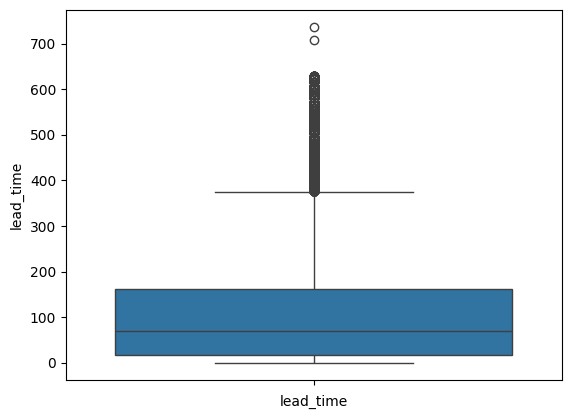

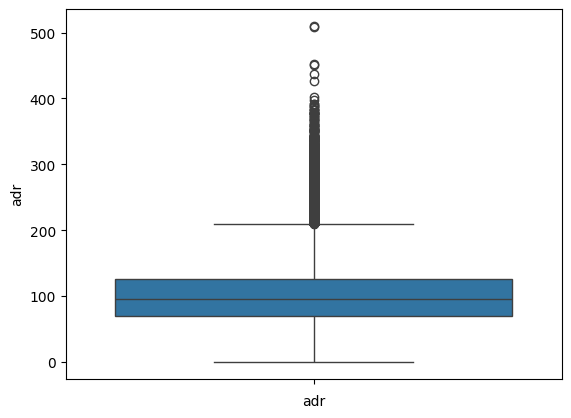

In [35]:
#Check for skewness using boxplots:
for i in continuous_columns:
    plt.figure()
    sns.boxplot(df[i])
    plt.xlabel(i)
    plt.show()

In [36]:
print('Skewness of Data:')
for i in continuous_columns:
    print(f'{i}: {df[i].skew()}')

Skewness of Data:
lead_time: 1.3436113622795318
adr: 1.0310956217904677


- Data is moderately skewed.